In [1]:
import psycopg2
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

import os
from dotenv import load_dotenv

load_dotenv()

database = "speed_data"
password = os.getenv("DB_PASSWORD")
user = os.getenv("DB_USER")

In [2]:
class ConnectDB():
    def __init__(self, database, user, password, host = "127.0.0.1", port = "5432"):
        self.__database = database
        self.__user = user
        self.__password = password
        self.__host = host
        self.__port = port

    def __enter__(self):
        self.__conn = psycopg2.connect(
            database = self.__database,
            user = self.__user,
            password = self.__password,
            host = self.__host,
            port = self.__port,
        )
        self.__conn.autocommit = True
        self.__cursor = self.__conn.cursor()
        return self
    
    def __exit__(self, type, value, traceback):
        self.__cursor.close()
        self.__conn.close()

    def execute(self, query, vars = None):
        self.__cursor.execute(query, vars)
    
    def select(self, query, vars = None):
        self.__cursor.execute(query, vars)
        return self.__cursor.fetchall()
    
    def get_data_speed(self):
        self.__cursor.execute("select timestamp, speed from messages where terminal_id='433427026902662' limit 1000")
        return [dict((self.__cursor.description[i][0], value) for i, value in enumerate(row)) for row in self.__cursor.fetchall()]
    
    def get_data_can(self):
        self.__cursor.execute("select timestamp, can_data from messages where terminal_id='433100526928099'")
        return [dict((self.__cursor.description[i][0], value) for i, value in enumerate(row)) for row in self.__cursor.fetchall()]

In [9]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.get_data_speed():
        x.append(datetime.fromtimestamp(i["timestamp"]))#.strftime("%Y.%m.%d %H:%M:%S"))
        y.append(i["speed"])

    x, y = np.array(x, dtype = np.datetime64), np.array(y)

    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

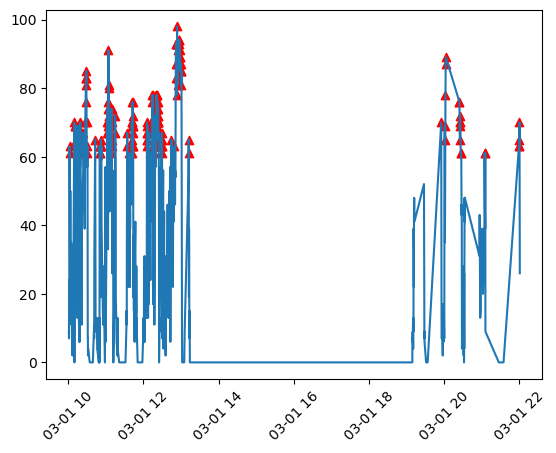

In [10]:
plt.plot(x, y)
plt.scatter(x[y > 60], y[y > 60], color = "r", marker = "^")
plt.xticks(rotation = 45)
plt.show()

### Задание 2
- На основе данных из поля can_data по id ‘433100526928099’, построить график.  
- Реализовать алгоритм детектирование заправок.  

In [5]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.get_data_can():
        x.append(datetime.fromtimestamp(i["timestamp"]))#.strftime("%Y.%m.%d %H:%M:%S"))
        y.append(i["can_data"]["LLS_0"])

    x, y = np.array(x, dtype = np.datetime64), np.array(y, dtype = float)

    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

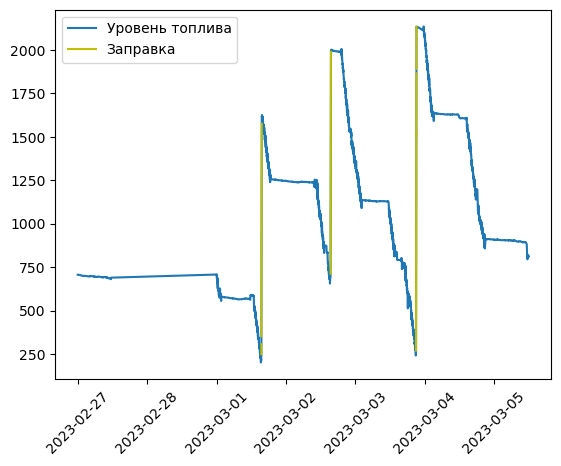

In [6]:
diff = y[1:] - y[:-1]
mask = np.full(x.size - 1, False)
for i in range(len(diff)):
    if diff[i] > 50:
        mask[i] = True
        mask[i - 1] = True
        mask[i + 1] = True

"""
Есть чуть более кривой вариант и быстрый вариант сделать задачу, но он 'съедает' часть точек
plt.plot(x[1:][diff > 50], y[1:][diff > 50], color = "r")
"""

masked_x = x.copy()[1:]
masked_x[~mask] = np.datetime64("NaT") # Для разрыва в функциях

plt.plot(x, y, label = "Уровень топлива")
plt.plot(masked_x, y[1:], color = "y", label = "Заправка")

plt.xticks(rotation = 45)
plt.legend()
plt.show()